# Kinetic Model for Styrene Polymerization

From: https://github.com/StochSS/GillesPy2/commit/2777b5e23d7cd3124a9000925ba4ff256f80cd03


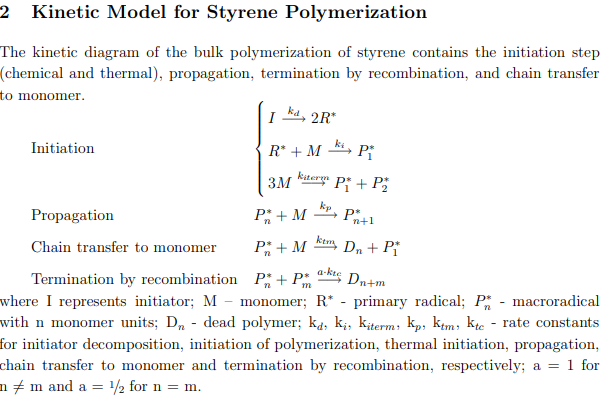

In [1]:
from IPython import display
print("From: https://github.com/StochSS/GillesPy2/commit/2777b5e23d7cd3124a9000925ba4ff256f80cd03")
display.Image("https://user-images.githubusercontent.com/85592612/121273574-ec503700-c89e-11eb-9aeb-ad425fd1f153.png")

**From:** Curteanu, Silvia. “Modeling and Simulation of Free Radical Polymerization of Styrene under Semibatch Reactor Conditions.” Open Chemistry, vol. 1, no. 1, 2003, pp. 69–90., doi:10.2478/bf02479259.

## Setup the Environment

In [2]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [3]:
from gillespy2 import (
    Model,
    Species,
    Parameter,
    Reaction,
    TimeSpan
)

## Building the Polymerization model in GillesPy2
Constructing this model in GillesPy2 reqires that we specify a maximum $n$ and $m$ that we are keeping track of. $n$, $m$, and $n+m$ must all be less than the maximum signed integer ($2^{31}-1$).  Then we create a new Species object for each state: $P_1$, $P_2$, ... $P_n$, and $D_1$, $D_2$, ... $D_{n+m}$.

In [4]:
def build_styrene_polymerization(MAX_N=10):
    # Initialize Model
    model = Model(name="StyrenePolymerization")

    # First, choose a maximum value for the states
    max_state = MAX_N
    print(f"Creating Styrene Polymerization model, MAX_N={MAX_N}")
    
    # Define Species
    I = Species(name="I", initial_value=100, mode="discrete")
    R = Species(name="R", initial_value=0, mode="discrete")
    M = Species(name="M", initial_value=100, mode="discrete")
    species = [I, R, M]
    
    for n in range(1, max_state):
        species.append(Species(name=f"P{n}", initial_value=0, mode="discrete"))
        species.append(Species(name=f"D{n}", initial_value=0, mode="discrete"))
        
    # Add Species to Model
    model.add_species(species)

    # Define Parameters
    k_d = Parameter(name="k_d", expression="1")
    k_i = Parameter(name="k_i", expression="1")
    k_iterm = Parameter(name="k_iterm", expression="1")
    k_p = Parameter(name="k_p", expression="1")
    k_tm = Parameter(name="k_tm", expression="1")
    
    # for the a=1/2
    k_tm_2 = Parameter(name="k_tm_2", expression="0.5")
    k_tc = Parameter(name="k_tc",   expression="1")
    
    # Add Parameters to Model
    model.add_parameter([k_d, k_i, k_iterm, k_p, k_tm, k_tm_2, k_tc])

    # Define Initiation Reactions
    r1 = Reaction(reactants={'I':1}, products={'R':2}, rate="k_d")
    r2 = Reaction(reactants={'R':1, 'M':1}, products={'P1':1}, rate="k_d")

    # Techically, you cannot have a trimer reaction is mass-action kinetics.
    # However, we can use a custom propensity to make it work.
    r3 = Reaction(reactants={'M':3}, products={'R':2}, propensity_function="k_iterm*M*(M-1)*(M-2)")
    reactions = [r1, r2, r3]

    # Define Propagation: P_n + M => P_{n+1}
    for n in range(1, max_state - 1):
        reactions.append(Reaction(reactants={f"P{n}": 1, 'M': 1}, products={f"P{n + 1}": 1}, rate="k_p"))

    # Define Chain transfer to monomer
    for n in range(1,max_state):
        reactions.append(Reaction(reactants={f"P{n}": 1, 'M': 1}, products={f"D{n}": 1, "P1": 1}, rate="k_tm"))

    # Define Termination by recombination
    for n in range(1, max_state):
        for m in range(1, max_state):
            nm = n + m
            if(nm < max_state):
                if(n == m):
                    reactions.append(
                        Reaction(reactants={f"P{n}": 1, f"P{m}": 1}, products={f"D{nm}": 1, "P1": 1}, rate="k_tm_2"
                    ))
                else:
                    reactions.append(
                        Reaction(reactants={f"P{n}": 1, f"P{m}": 1}, products={f"D{nm}": 1, "P1": 1}, rate="k_tm"
                    ))
                    
    # Add Reactions to Model
    model.add_reaction(reactions)
    
    # Define Timespace
    tspan = TimeSpan.arange(t=20, increment=0.1)

    # Timespan: 0 -> 20 seconds
    model.timespan(tspan)
    return model

### Instantiate the Model

In [5]:
model = build_styrene_polymerization()

Creating Styrene Polymerization model, MAX_N=10


## Run the Simulation

In [6]:
%time result = model.run()

CPU times: user 63.2 ms, sys: 57.1 ms, total: 120 ms
Wall time: 1.81 s


## Visualization

In [7]:
result.plotplotly()

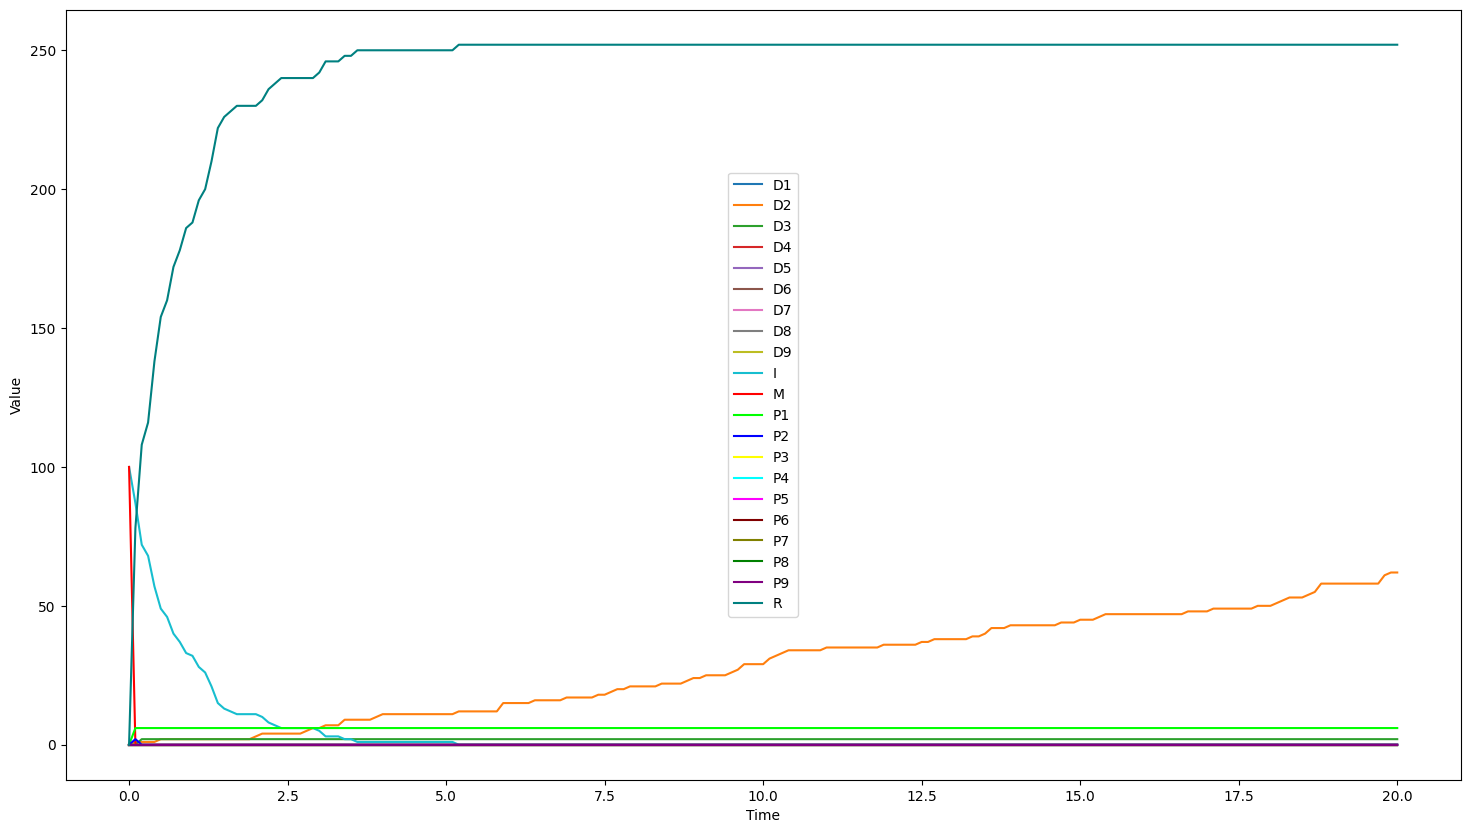

In [8]:
result.plot()